In [ ]:
# do this only if there is a Zip, this was a colab 
import zipfile
with zipfile.ZipFile('asl_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('asl_dataset')

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path

def augment_brightness(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    aug = np.random.uniform(0.25, 2)
    img[:, :, 2] = img[:, :, 2] * aug
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

def augment_contrast(image):
    contrast = np.random.uniform(0.25, 2)
    return cv2.convertScaleAbs(image, alpha=contrast)

def augment_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 0.1 * np.random.uniform(0, 1)
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = image + gauss.reshape(row, col, ch)
    return np.clip(noisy, 0, 255).astype(np.uint8)

def augment_scale(image):
    scale = np.random.uniform(0.25, 2)
    height, width = image.shape[:2]
    new_height, new_width = int(height * scale), int(width * scale)
    return cv2.resize(image, (new_width, new_height))

def augment_shear(image):
    rows, cols, ch = image.shape
    shear_factor = np.random.uniform(-0.5, 0.5)
    M = np.array([[1, shear_factor, 0],
                    [0, 1, 0]])
    return cv2.warpAffine(image, M, (cols, rows))

def save_img(image, output_path, suffix):
    output_dir = Path(output_path).parent
    output_dir.mkdir(parents=True, exist_ok=True)
    output_filename = f"{Path(output_path).stem}_{suffix}{Path(output_path).suffix}"
    cv2.imwrite(str(output_dir / output_filename), image)

# update image location as needed
og_imgs = '/content/asl_dataset/asl_dataset'
out = 'asl_dataset_augmented'
Path(out).mkdir(parents=True, exist_ok=True)

for root, _, files in os.walk(og_imgs):
    for file in files:
        if file.endswith(('.jpeg')):
            file_path = os.path.join(root, file)
            image = cv2.imread(file_path)
            path = os.path.relpath(file_path, og_imgs)
            save_img(image, os.path.join(out, path), 'original')

            for i in range(5):
                brightness_image = augment_brightness(image)
                contrast_image = augment_contrast(image)
                noise_image = augment_noise(image)
                scale_image = augment_scale(image)
                sheer_image = augment_shear(image)

                save_img(brightness_image, os.path.join(out, path), f'brightness_{i}')
                save_img(contrast_image, os.path.join(out, path), f'contrast_{i}')
                save_img(noise_image, os.path.join(out, path), f'noise_{i}')
                save_img(scale_image, os.path.join(out, path), f'scale_{i}')
                save_img(sheer_image, os.path.join(out, path), f'sheer_{i}')



In [5]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import cv2 as cv

In [31]:
# Load training data from 'asl_dataset_augmented' folder with target size 224x224 and grayscale mode
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'asl_dataset_augmented',
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

# Load validation data
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    'asl_dataset_augmented',
    validation_split=0.1,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

# Load test data (using the same validation split for simplicity)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'asl_dataset_augmented',
    validation_split=0.1,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

Found 65390 files belonging to 36 classes.
Using 52312 files for training.
Found 65390 files belonging to 36 classes.
Using 6539 files for validation.
Found 65390 files belonging to 36 classes.
Using 6539 files for validation.


In [32]:

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(224,224,1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(72, activation='relu'),
    layers.Dense(36, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 346112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 72)                  │      24,920,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 36)                  │           2,628 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,015,436 (95.43 MB)

 Trainable params: 25,015,436 (95.43 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from keras.callbacks import ModelCheckpoint

In [35]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filepath to save the model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode for the metric ('max' for accuracy, 'min' for loss)
    verbose=1  # Print information about model saving
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    batch_size=512,
    verbose=True,
    callbacks=[checkpoint] # Add the callback to the fit method
)

Epoch 1/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8029 - loss: 2.8180
Epoch 1: val_accuracy improved from -inf to 0.97416, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 112s 66ms/step - accuracy: 0.8030 - loss: 2.8167 - val_accuracy: 0.9742 - val_loss: 0.0980
Epoch 2/15
1634/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9800 - loss: 0.0665
Epoch 2: val_accuracy improved from 0.97416 to 0.97568, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.9800 - loss: 0.0665 - val_accuracy: 0.9757 - val_loss: 0.0979
Epoch 3/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9890 - loss: 0.0393
Epoch 3: val_accuracy improved from 0.97568 to 0.97630, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.9890 - loss: 0.0393 - val_accuracy: 0.9763 - val_loss: 0.0917
Epoch 4/15
1634/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9901 - loss: 0.0301
Epoch 4: val_a

In [36]:
model.evaluate(test_dataset)

205/205 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9839 - loss: 0.1638


[0.17503884434700012, 0.9837895631790161]

In [37]:
model.save('cnn_25_epoch.keras')
model.save_weights('cnn_25_epoch_weights.weights.h5')

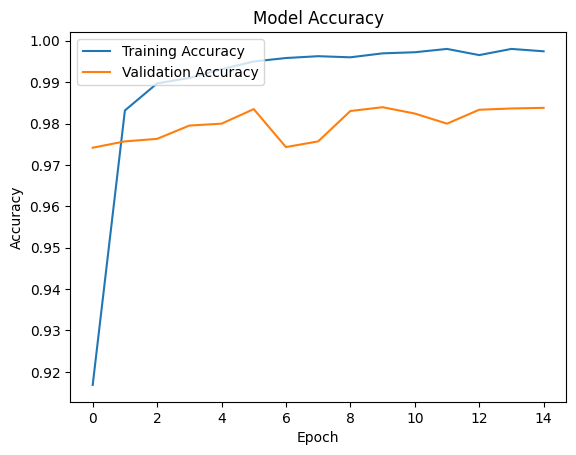

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()
